# Trojan thermal model proof of concept



## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Import thermal model components
from core.config_manager import ConfigManager, create_default_base_config
from core.thermal_simulation import ThermalSimulator
from modelmain import Simulator
from config import SimulationConfig
from modelmain import fit_blackbody_wn_banded, max_btemp_blackbody, emissionT

# Import the new radiance processing framework
from radiance_processor import calculate_radiances_from_results, recompute_radiance_with_angles

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

print("Imports completed successfully!")
print("✓ New radiance processing framework imported")

Imports completed successfully!
✓ New radiance processing framework imported


## Create and Load Base Simulation Configuration

Create and load in a default config file. 

In [2]:
# Option 1: Create a new default configuration
config_path = "../configs/base_configs/analysis_template.yaml"

# Create config directory if it doesn't exist
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Create default configuration for analysis
create_default_base_config(config_path)

# Load the configuration
config_manager = ConfigManager(config_path)

# Create base configuration
base_config = config_manager.create_config()

print(f"Configuration created at: {config_path}")
print(f"Loaded configuration.")


Default configuration saved to: ../configs/base_configs/analysis_template.yaml
Configuration created at: ../configs/base_configs/analysis_template.yaml
Loaded configuration.


## Run Isothermal Spectrum Simulation



In [3]:
# Modify base configuration for our analysis
analysis_overrides = {
    'diurnal': False,                       # Steady state simulation
    'sun': False,                           # Include solar heating
    'T_fixed': True,                        # Temperature is fixed, prevents thermal evolution
    'compute_observer_radiance': True,      # Compute radiance outputs. 
    'thermal_evolution_mode': 'two_wave',   #Run thermal evolution later with broadband vis (turned off) and broadband thermal. 
    'output_radiance_mode': 'hybrid',       #Compute spectral radiance in thermal only. 
    'observer_mu': 1.0,                     # Observer zenith angle (0 for nadir)
    'Et': 100000,                          # Mean extinction coefficient. Some spikes as high as 800,000!
    'ssalb_therm': 0.6,                     # Single scattering albedo for thermal radiation (average from mie code). As high as 0.7 at short wavelengths. 
    'g_therm': 0.7,                         # Asymmetry parameter for thermal radiation (average from mie code)
    'R_base': 0.0,                          # Global reflectivity value for substrate     
    'disort_space_temp': 0.0,              # Cold shroud temperature
    'k_dust': 4.2e-4,                       # Phonon thermal conductivity of dust (W/m/K)
    'single_layer': True,                   # Use single-layer model
    'dust_thickness': 0.20,                # 10 cm
    'T_bottom': 150,                        # Sample base fixed at 500 K
    'bottom_bc': 'dirichlet',               # Bottom boundary condition (fixed temperature)
    'fill_frac': 0.25,                      #Fill fraction for particles. 
    'radius': 0.5e-6,                       #Particle radius in meters.
    'mie_file_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/fay_0.5_mstm_combined_0.25.txt',  # Mie file for output
    'wn_bounds_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/Fayalite_mstm_wn_bounds.txt',  # Wavenumber bounds for output files,
    'nstr_out': 32,                # Number of streams for output
    'nmom_out': 32                # Number of moments for output
}

# Create configuration with overrides
config1 = config_manager.create_config(analysis_overrides)

print("Running baseline simulation...")
print(f"Configuration: Et={config1.Et}, k_dust={config1.k_dust}, thickness={config1.dust_thickness}m")

# Run simulation
sim1 = Simulator(config1)
T_out1, phi_vis1, phi_therm1, T_surf1, t_out1 = sim1.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

Running baseline simulation...
Configuration: Et=100000, k_dust=0.00042, thickness=0.2m
Time step: 0.000540 s, Steps per day: 28601653
Thermal evolution mode: two_wave
Non-diurnal step 0, time=0.00s
Simulation completed in 0.00 s
Simulation completed! Output shape: (204, 1)
Time range: 0 to 0 seconds
Surface temperature range: 150.0 to 150.0 K


## Plot isothermal spectrum

No temperature gradient, approximate for an ambient lab measurement. 

Computing radiance using new framework...
Auto-detected simulation object, extracting data...
Computing surface radiances for 1 observers and 1 time points...
  Observer 1/1 (mu=1.000, angle=0.0°)
Surface radiance calculation completed.


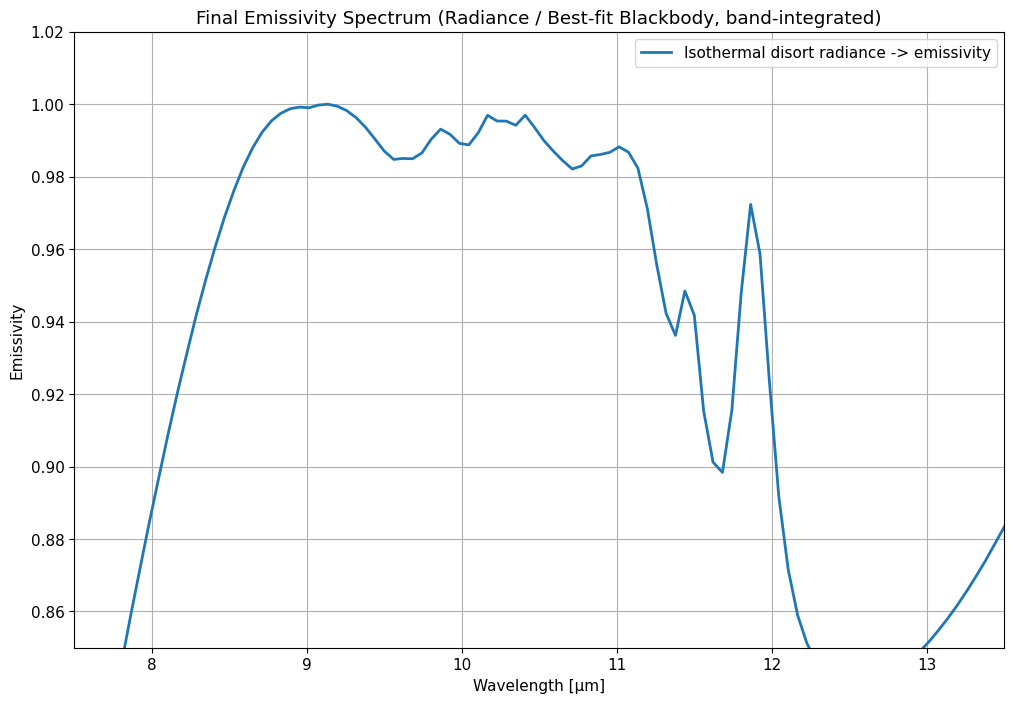

✓ Isothermal radiance computed using new framework
  Shape: (1, 100, 1)
  Spectral mode: hybrid
  Observer angles: [0.0]°


In [11]:
# Plot isothermal spectrum using the new radiance processing framework
print("Computing radiance using new framework...")
radiance_results1 = calculate_radiances_from_results(sim1)

# Extract results
wn = radiance_results1['wavenumbers']
final_rad = radiance_results1['radiance_thermal'][0,:, 0]  # [wavelengths] for single observer
ir_cutoff = np.argmin(np.abs(wn - 1500))  # cm^-1, cutoff for IR bands

# Read bin edges from config
wn_bounds = np.sort(np.loadtxt(sim1.cfg.wn_bounds_out))
T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim1, wn_bounds, final_rad)
emiss_spec = final_rad/B_fit

# Normalize emissivity
idx1 = np.argmin(np.abs(wn - 900))
idx2 = np.argmin(np.abs(wn - 1700))
ds_cf_emis = emiss_spec[idx1:idx2+1].max()

# Also compute flux-based emissivity for comparison
if 'flux_thermal' in radiance_results1:
    final_flux = radiance_results1['flux_thermal'][0,:, -1]  # Final flux at last time step
    T_fit_flux, B_fit_flux, btemps_flux, wn_BB_flux = max_btemp_blackbody(sim1, wn_bounds, final_flux/np.pi)
    emiss_spec_flux = final_flux/B_fit_flux
    ds_cf_emis_flux = emiss_spec_flux[idx1:idx2+1].max()  # Max emissivity in this range
else:
    # Fallback for compatibility
    final_flux = sim1.flux_out[:, -1]
    T_fit_flux, B_fit_flux, btemps_flux, wn_BB_flux = max_btemp_blackbody(sim1, wn_bounds, final_flux/np.pi)
    emiss_spec_flux = final_flux/B_fit_flux
    ds_cf_emis_flux = emiss_spec_flux[idx1:idx2+1].max()


plt.figure()
#plt.plot(wn_BB, emiss_spec + otes_cf_emis - bbfit_cf_emis, label=f'Emissivity (T_fit={T_fit:.1f} K)')
#plt.plot(multi_wn_BB, multi_emiss_spec, label=f'Mixture Emissivity (T_fit={multi_T_fit})')
plt.plot(10000./wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal disort radiance -> emissivity',linewidth=2)
#plt.plot(10000./wn[:ir_cutoff],emiss_spec_flux[:ir_cutoff]+1-ds_cf_emis_flux, label=f'Isothermal disort flux emissivity (T_fit={T_fit_flux:.1f} K)', linestyle='--', linewidth=2)
plt.xlabel('Wavelength [µm]')
plt.ylabel('Emissivity')
plt.xlim([7.5,13.5])
plt.ylim([0.85, 1.02])
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.legend()
plt.grid(True)
#plt.gca().invert_xaxis()
plt.show()

print(f"✓ Isothermal radiance computed using new framework")
print(f"  Shape: {radiance_results1['radiance_thermal'].shape}")
print(f"  Spectral mode: {radiance_results1['spectral_mode']}")
print(f"  Observer angles: {radiance_results1['observer_angles_deg']}°")

## Run thermal evolution model for lunar environmental chamber conditions. 



In [12]:

# Allow thermal evolution now. 
analysis_overrides['T_fixed'] = False
analysis_overrides['steady_tol'] = 1.5e-6  # Convergence tolerance for steady state (K)
analysis_overrides['dtfac'] = 50
analysis_overrides['sun'] = True
analysis_overrides['steady_state_mu'] = np.cos(np.radians(30.0))  # Solar incidence angle cosine for steady state runs with the sun turned on.
analysis_overrides['R'] = 5.0 #Heliocentric distance in AU, 5.0 for Jupiter Trojans

analysis_overrides['ssalb_vis'] = 0.06
config2 = config_manager.create_config(analysis_overrides)

# Run simulation
sim2 = Simulator(config2)
T_out2, phi_vis2, phi_therm2, T_surf2, t_out2 = sim2.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")



Time step: 0.000540 s, Steps per day: 28601653
Thermal evolution mode: two_wave
Non-diurnal step 0, time=0.00s
[Steady-state check] step 200, max |T - T_ext| = 4.631e-02 K
[Steady-state check] step 400, max |T - T_ext| = 3.621e-02 K
[Steady-state check] step 600, max |T - T_ext| = 3.087e-02 K
[Steady-state check] step 800, max |T - T_ext| = 2.644e-02 K
[Steady-state check] step 1000, max |T - T_ext| = 2.271e-02 K
Non-diurnal step 1000, time=0.54s
[Steady-state check] step 1200, max |T - T_ext| = 2.118e-02 K
[Steady-state check] step 1400, max |T - T_ext| = 1.975e-02 K
[Steady-state check] step 1600, max |T - T_ext| = 1.842e-02 K
[Steady-state check] step 1800, max |T - T_ext| = 1.720e-02 K
[Steady-state check] step 2000, max |T - T_ext| = 1.606e-02 K
Non-diurnal step 2000, time=1.08s
[Steady-state check] step 2200, max |T - T_ext| = 1.612e-02 K
[Steady-state check] step 2400, max |T - T_ext| = 1.508e-02 K
[Steady-state check] step 2600, max |T - T_ext| = 1.410e-02 K
[Steady-state check

In [ ]:


# Run simulation
analysis_overrides['sun'] = False
analysis_overrides['steady_tol'] = 1.5e-6  # Convergence tolerance for steady state (K)
analysis_overrides['dtfac'] = 50
config3 = config_manager.create_config(analysis_overrides)

sim3 = Simulator(config3)
T_out3, phi_vis3, phi_therm3, T_surf3, t_out3 = sim3.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

## Plot vacuum thermal gradient

In [ ]:
plt.plot(T_out2[1:,-1],sim2.grid.x[1:]/sim2.cfg.Et * 1e6)
plt.plot(T_out3[1:,-1],sim3.grid.x[1:]/sim3.cfg.Et * 1e6)
plt.ylabel('Depth into medium [µm]')
plt.xlabel('Temperature  [K]')
plt.ylim([0,1000])
#plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

plt.plot(T_out2[1:,-1] ,sim2.grid.x[1:])
plt.plot(T_out3[1:,-1] ,sim3.grid.x[1:])
plt.ylabel('Depth into medium [tau]')
plt.xlabel('Temperature  [K]')
plt.ylim([0,3])
#plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

## Plot vacuum spectrum

In [ ]:
# Plot vacuum spectra comparison using new framework
print("Computing vacuum radiance using new framework...")

# Compute radiances for both vacuum simulations
radiance_results2 = calculate_radiances_from_results(sim2)  # Daytime simulation
radiance_results3 = calculate_radiances_from_results(sim3)  # Nighttime simulation

# Extract vacuum results
final_rad2 = radiance_results2['radiance_thermal'][:, -1]  # Daytime
final_rad3 = radiance_results3['radiance_thermal'][:, -1]  # Nighttime

# Compute brightness temperatures and emissivities
T_fit2, B_fit2, btemps2, wn_BB2 = max_btemp_blackbody(sim2, wn_bounds, final_rad2)
emiss_spec2 = final_rad2/B_fit2
ds_cf_emis2 = emiss_spec2[idx1:idx2+1].max()

T_fit3, B_fit3, btemps3, wn_BB3 = max_btemp_blackbody(sim3, wn_bounds, final_rad3)
emiss_spec3 = final_rad3/B_fit3
ds_cf_emis3 = emiss_spec3[idx1:idx2+1].max()

# Create comprehensive comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Radiance comparison
ax1.plot(10000./wn[:ir_cutoff], final_rad2[:ir_cutoff], label='Vacuum daytime radiance', linewidth=2)
ax1.plot(10000./wn[:ir_cutoff], B_fit2[:ir_cutoff], label='Best-fit blackbody (daytime)', linestyle='--', linewidth=2)
ax1.plot(10000./wn[:ir_cutoff], final_rad3[:ir_cutoff], label='Vacuum nighttime radiance', linewidth=2)
ax1.plot(10000./wn[:ir_cutoff], B_fit3[:ir_cutoff], label='Best-fit blackbody (nighttime)', linestyle='--', linewidth=2)
ax1.set_xlabel('Wavelength [µm]')
ax1.set_ylabel('Radiance [W m⁻² sr⁻¹ (cm⁻¹)⁻¹]')
ax1.set_title('Radiance Spectra Comparison')
ax1.set_xlim([7.5, 13.2])
ax1.legend()
ax1.grid(True)

# Plot 2: Emissivity in wavenumber space
ax2.plot(wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal (T_fit={T_fit:.1f}K)', linewidth=2)
ax2.plot(wn[:ir_cutoff], emiss_spec2[:ir_cutoff], label=f'Vacuum daytime (T_fit={T_fit2:.1f}K)', linewidth=2)
ax2.plot(wn[:ir_cutoff], emiss_spec3[:ir_cutoff], label=f'Vacuum nighttime (T_fit={T_fit3:.1f}K)', linewidth=2)
ax2.set_xlabel('Wavenumber [cm⁻¹]')
ax2.set_ylabel('Emissivity')
ax2.set_title('Emissivity Comparison (Wavenumber Space)')
ax2.legend()
ax2.grid(True)
ax2.invert_xaxis()

# Plot 3: Emissivity in wavelength space
ax3.plot(10000./wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal (T_fit={T_fit:.1f}K)', linewidth=2)
ax3.plot(10000./wn[:ir_cutoff], emiss_spec2[:ir_cutoff]+1-ds_cf_emis2, label=f'Vacuum daytime (T_fit={T_fit2:.1f}K)', linewidth=2)
ax3.plot(10000./wn[:ir_cutoff], emiss_spec3[:ir_cutoff]+1-ds_cf_emis3, label=f'Vacuum nighttime (T_fit={T_fit3:.1f}K)', linewidth=2)
ax3.set_xlabel('Wavelength [µm]')
ax3.set_ylabel('Normalized Emissivity')
ax3.set_title('Normalized Emissivity Comparison (Wavelength Space)')
ax3.set_xlim([7.5,13.5])
ax3.set_ylim([0., 1.02])
ax3.legend()
ax3.grid(True)

# Plot 4: Temperature difference analysis
temp_diffs_2 = T_out2[1:,-1] - sim2.cfg.T_bottom  # Daytime temperature profile
temp_diffs_3 = T_out3[1:,-1] - sim3.cfg.T_bottom  # Nighttime temperature profile
depths_um = sim2.grid.x[1:]/sim2.cfg.Et * 1e6  # Convert to micrometers

ax4.plot(temp_diffs_2, depths_um, label=f'Daytime (Surface: {T_out2[0,-1]:.1f}K)', linewidth=2)
ax4.plot(temp_diffs_3, depths_um, label=f'Nighttime (Surface: {T_out3[0,-1]:.1f}K)', linewidth=2)
ax4.set_xlabel('Temperature Difference from Base [K]')
ax4.set_ylabel('Depth [µm]')
ax4.set_title('Thermal Gradient Comparison')
ax4.set_ylim([0, 1000])
ax4.legend()
ax4.grid(True)
ax4.invert_yaxis()

plt.suptitle('Trojan Asteroid Study: Thermal Gradient Effects on Fayalite Spectra', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Quantitative comparison
print(f"\n=== QUANTITATIVE COMPARISON ===")
print(f"Isothermal case:")
print(f"  • Brightness temperature: {T_fit:.1f} K")
print(f"  • Peak emissivity: {emiss_spec.max():.3f}")
print(f"  • Surface temperature: {T_out1[0,-1]:.1f} K")

print(f"\nVacuum daytime case:")
print(f"  • Brightness temperature: {T_fit2:.1f} K") 
print(f"  • Peak emissivity: {emiss_spec2.max():.3f}")
print(f"  • Surface temperature: {T_out2[0,-1]:.1f} K")

print(f"\nVacuum nighttime case:")
print(f"  • Brightness temperature: {T_fit3:.1f} K")
print(f"  • Peak emissivity: {emiss_spec3.max():.3f}")  
print(f"  • Surface temperature: {T_out3[0,-1]:.1f} K")

# Calculate differences
temp_diff_day = T_fit2 - T_fit
temp_diff_night = T_fit3 - T_fit
emiss_diff_day = np.abs(emiss_spec2 - emiss_spec).max()
emiss_diff_night = np.abs(emiss_spec3 - emiss_spec).max()

print(f"\nDifferences from isothermal:")
print(f"  • Daytime temperature difference: {temp_diff_day:.1f} K")
print(f"  • Nighttime temperature difference: {temp_diff_night:.1f} K")
print(f"  • Max daytime emissivity difference: {emiss_diff_day:.4f}")
print(f"  • Max nighttime emissivity difference: {emiss_diff_night:.4f}")

print(f"\n✓ All simulations processed using new radiance framework")
print(f"✓ Radiance processing modes:")
print(f"  - Isothermal: {radiance_results1['spectral_mode']}")
print(f"  - Vacuum daytime: {radiance_results2['spectral_mode']}")
print(f"  - Vacuum nighttime: {radiance_results3['spectral_mode']}")
print(f"✓ Comprehensive thermal gradient analysis completed")